In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
# resize the image
IMAGE_RESIZE_X=200
IMAGE_RESIZE_Y= 200

### Read car images and resize

In [3]:

#  car image path
path ="/content/drive/MyDrive/archive/images"

car_image_name_list = list()
for car_image in os.listdir(path):
  full_path = os.path.join(path,car_image)
  car_image_name_list.append(full_path)
# sort the cars by their index in ascendin order
car_image_name_list = sorted(car_image_name_list,key = lambda x:int(x.split("/")[-1].split(".")[0][4:]))

#  read car images and resize
resized_car_images_list = list()
for full_path in car_image_name_list:
  car_image = cv2.imread(full_path)
  car_resized_image = cv2.resize(car_image,(IMAGE_RESIZE_X,IMAGE_RESIZE_Y))
  resized_car_images_list.append(np.array(car_resized_image))
print("Read {} resized car images".format(len(resized_car_images_list)))

Read 433 resized car images


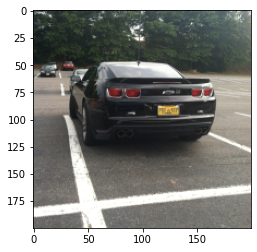

In [4]:
plt.imshow(cv2.cvtColor(resized_car_images_list[2],cv2.COLOR_BGR2RGB))
plt.show()

### read license palate annotation and resize them

In [5]:
annotation_folder_path = "/content/drive/MyDrive/archive/annotations"

plate_name_list = list()
for plate_file in os.listdir(annotation_folder_path):
  full_path = os.path.join(annotation_folder_path,plate_file)
  plate_name_list.append(full_path)
plate_name_list = sorted(plate_name_list, key= lambda x: int(x.split("/")[-1].split(".")[0][4:]))

resized_plate_location_list = list()
for full_path in plate_name_list:
  xml_file = open(full_path,"r")
  bs = BeautifulSoup(xml_file,"xml")
  width = int(bs.find("width").text)
  height = int(bs.find("height").text)
  xmax = int(bs.find("xmax").text) * (IMAGE_RESIZE_X / width)
  xmin = int(bs.find("xmin").text) * (IMAGE_RESIZE_X / width)
  ymax = int(bs.find("ymax").text) * (IMAGE_RESIZE_Y / height)
  ymin = int(bs.find("ymin").text) * (IMAGE_RESIZE_Y / height)
  resized_plate_location_list.append([int(xmax), int(xmin), int(ymax), int(ymin)])
print('Read in {} resized plate info'.format(len(plate_name_list)))

Read in 433 resized plate info


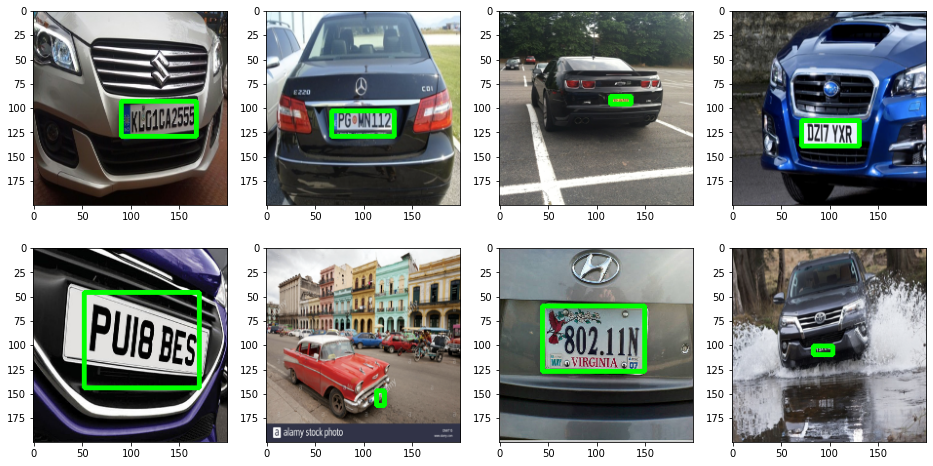

In [6]:
plt.figure(figsize = (16,8))
for i in range(8):
  plt.subplot(2,4,i+1)
  #locate the plate location based on label
  top_left = (resized_plate_location_list[i][1],resized_plate_location_list[i][3])
  bottom_right = (resized_plate_location_list[i][0],resized_plate_location_list[i][2])

  # draw bounding box on the copy of resized car iamge so that we have original image to train
  car_image_copy = resized_car_images_list[i].copy()

  #display the car images with plate around
  cv2.rectangle(car_image_copy,top_left,bottom_right,(0,255,0), thickness=3)
  plt.imshow(cv2.cvtColor(car_image_copy,cv2.COLOR_BGR2RGB))


In [7]:
def splitTrainTestSet():
  # X would be the array representation of resized car image
  # y would be the plate location 

  resized_car_images_list_np = np.array(resized_car_images_list)
  resized_plate_location_list_np = np.array(resized_plate_location_list)

  # normalization
  normalized_X = resized_car_images_list_np/255 # make all pixel color ranges from 0 to 1 instead of 0 to 255
  normalized_y = resized_plate_location_list_np/200

  X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, test_size=0.1, random_state=7)
  
  return X_train, X_test, y_train, y_test

In [8]:

def setupModel(modelType):
  cnn = keras.models.Sequential()

  if modelType == 'VGG16':
    cnn.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_RESIZE_X, IMAGE_RESIZE_Y, 3)))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(64, activation="relu"))
    # we want the output with 4 points which are the four corners of the plate
    cnn.add(Dense(4, activation="sigmoid"))
    #cnn.layers[-6].trainable = False
  
  elif modelType == 'cnn':
    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=5, input_shape=(IMAGE_RESIZE_X,IMAGE_RESIZE_Y,3), padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(keras.layers.Dropout(0.1))
    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    # fully connected layer
    cnn.add(Dense(128, activation="relu"))
    cnn.add(Dense(64, activation="relu"))
    # we want the output with 4 points which are the four corners of the plate
    cnn.add(keras.layers.Dense(4, activation="sigmoid"))

  return cnn

In [9]:

import keras
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

cnn = setupModel(modelType='VGG16')
cnn.summary()

X_train, X_test, y_train, y_test  = splitTrainTestSet()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 6, 6, 512)         0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                         

In [10]:
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

train = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 44s 3s/step - loss: 0.0675 - accuracy: 0.4576 - val_loss: 0.0318 - val_accuracy: 0.4545
Epoch 2/50
8/8 [==============================] - 4s 514ms/step - loss: 0.0286 - accuracy: 0.4884 - val_loss: 0.0319 - val_accuracy: 0.4545
Epoch 3/50
8/8 [==============================] - 4s 515ms/step - loss: 0.0280 - accuracy: 0.5090 - val_loss: 0.0311 - val_accuracy: 0.5455
Epoch 4/50
8/8 [==============================] - 4s 514ms/step - loss: 0.0277 - accuracy: 0.5398 - val_loss: 0.0299 - val_accuracy: 0.5455
Epoch 5/50
8/8 [==============================] - 4s 515ms/step - loss: 0.0272 - accuracy: 0.5296 - val_loss: 0.0291 - val_accuracy: 0.5455
Epoch 6/50
8/8 [==============================] - 4s 515ms/step - loss: 0.0272 - accuracy: 0.5424 - val_loss: 0.0313 - val_accuracy: 0.6136
Epoch 7/50
8/8 [==============================] - 4s 516ms/step - loss: 0.0271 - accuracy: 0.5501 - val_loss: 0.0296 - val_accuracy: 0.5682
Epoch 8/50
8/8 [======

In [12]:
scores = cnn.evaluate(X_test, y_test, verbose=0)
scores

[0.0149603970348835, 0.9090909361839294]

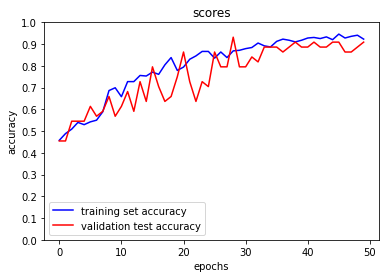

In [15]:
accuracy = train.history["accuracy"]
val_accuracy = train.history["val_accuracy"]
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,"b",label = "training set accuracy")
plt.plot(epochs,val_accuracy,"r",label = "validation test accuracy")
plt.title("scores")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.yticks(np.linspace(0,1,11))
plt.legend()
plt.show()

In [27]:
# read car images and resize
test_image_folder = '/content/drive/MyDrive/archive/'
test_image_list = ['img1.jpg', 'img5.jpg', 'img7.jpg']
resized_test_image_list = list()
orginal_test_image_list = list()
test_image_orginal_size = list()
for test_image in test_image_list:
  full_path = os.path.join(test_image_folder, test_image)
  car_image = cv2.imread(full_path)
  orginal_test_image_list.append(car_image)
  test_image_orginal_size.append(car_image.shape)
  car_resize_image = cv2.resize(car_image, (IMAGE_RESIZE_X,IMAGE_RESIZE_Y))
  resized_test_image_list.append(np.array(car_resize_image))
resized_test_image_list = np.array(resized_test_image_list)
#normalization
# this is the important because cnn networks takes normalized input
resized_test_image_list = resized_test_image_list / 255

### make prediction

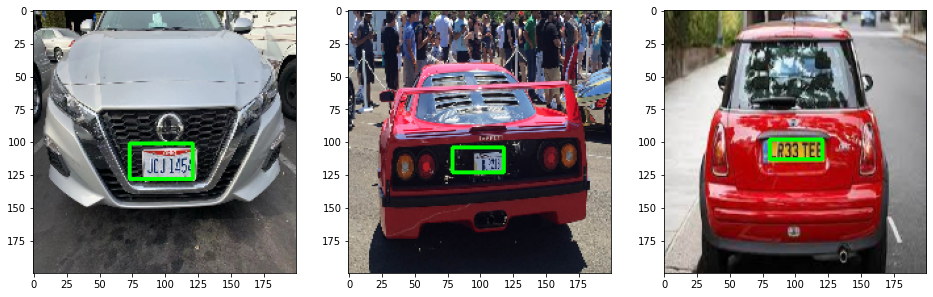

In [28]:
plate_location = cnn.predict(resized_test_image_list)
# plot the result
plt.figure(figsize =(16,8))
for i in range(3):
  plt.subplot(1,3,i+1)
  # draw bounding box on the copy of resized car image so that we have orginal image
  car_image_copy = resized_test_image_list[i].copy()
  car_image_copy = car_image_copy *255 # get original car image size
  car_image_copy = car_image_copy.astype("uint8") # cast to uint8 so that we can plot with normal RGB color

  # loacte the plate location based on label
  # the output of the cnn is still normalized output so we need to get the original diamension
  top_left = (int(plate_location[i][1]*200), int(plate_location[i][3]*200))
  bottom_right = (int(plate_location[i][0]*200), int(plate_location[i][2]*200))

  # display car image with plate
  cv2.rectangle(car_image_copy, top_left, bottom_right,color =(0,255,0), thickness =2)
  plt.imshow(cv2.cvtColor(car_image_copy, cv2.COLOR_BGR2RGB))


In [30]:
# get the location of the detected plate in original image size
plate_location_origianl_scale = list()
for i in range(len(test_image_orginal_size)):
  # this is the location before normalisation
  plate_location_resized = plate_location[i] * 200
  test_image_size = test_image_orginal_size[i]
  height, width = test_image_size[0], test_image_size[1]

  original_xmax = plate_location_resized[0] * (width /IMAGE_RESIZE_X)
  origina_xmin = plate_location_resized[1] * (width / IMAGE_RESIZE_X)
  original_ymax = plate_location_resized[2] * (height / IMAGE_RESIZE_Y)
  original_ymin = plate_location_resized[3] * (height /IMAGE_RESIZE_Y)
  plate_location_origianl_scale.append([int()])


# get the location of the detected plate in original image size
plate_location_origianl_scale = list()
for i in range(len(test_image_orginal_size)):
  # this is the location before normalization
  plate_location_resized = plate_location[i] * 200
  test_image_size = test_image_orginal_size[i]
  height, width = test_image_size[0], test_image_size[1]

  original_xMax = plate_location_resized[0] * (width / IMAGE_RESIZE_X)
  original_xMin = plate_location_resized[1] * (width / IMAGE_RESIZE_X)
  original_yMax = plate_location_resized[2] * (height / IMAGE_RESIZE_Y)
  original_yMin = plate_location_resized[3] * (height / IMAGE_RESIZE_Y)
  plate_location_origianl_scale.append([int(original_xMax), int(original_xMin), int(original_yMax), int(original_yMin)])


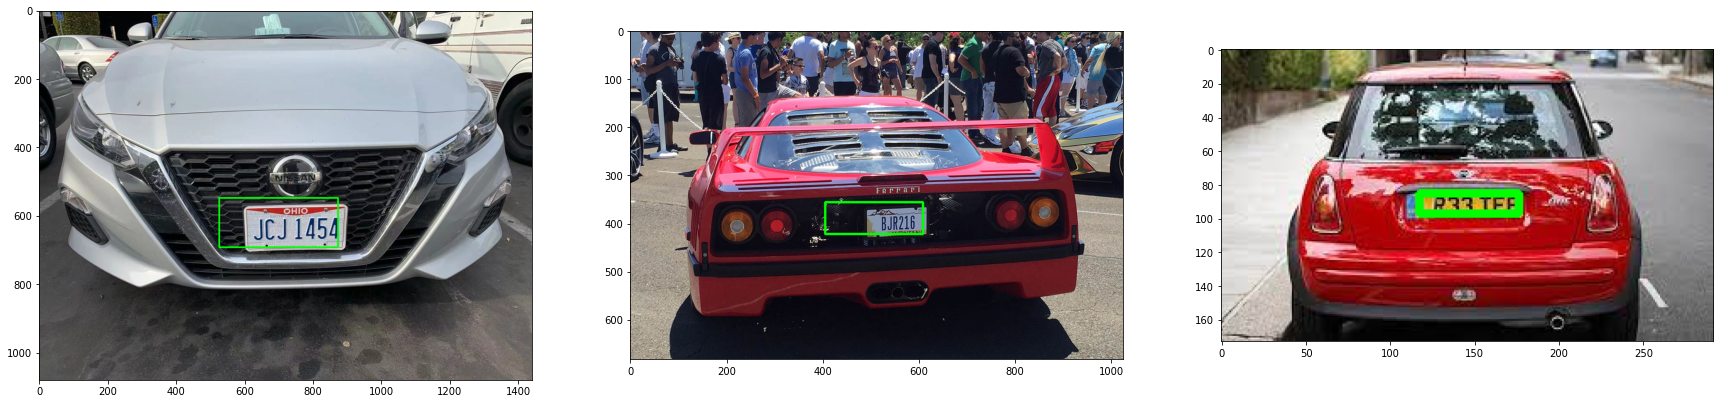

In [32]:
#  plot the detected plate with car in the orginal images
plt.figure(figsize=(30,10))
for i in range(len(orginal_test_image_list)):
  plt.subplot(1,len(orginal_test_image_list), i+1)
  # copy the original image so that the original image unchanged
  image_copy = orginal_test_image_list[i].copy()
  # locate the corner of the plate
  top_left = (plate_location_origianl_scale[i][1], plate_location_origianl_scale[i][3])
  bottom_right = (plate_location_origianl_scale[i][0], plate_location_origianl_scale[i][2])

  # display plate
  cv2.rectangle(image_copy,top_left,bottom_right, color = (0,255,0), thickness= 3)
  plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))

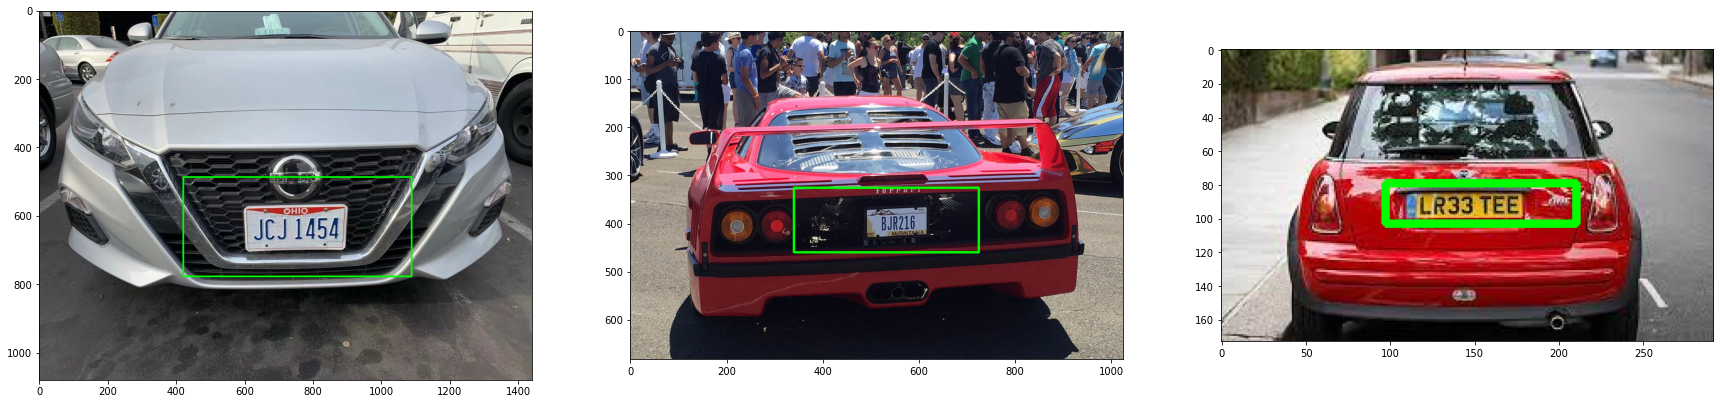

In [33]:

#since the cnn cannot predict the plate location with 100% accuracy, we can enlarge the size of the bounding box so that it covers the complete plate
plate_image_list = list()
# plot the detected plate with car in the original images
plt.figure(figsize=(30,10))
for i in range(len(orginal_test_image_list)):
  plt.subplot(1, len(orginal_test_image_list), i+1)
  image_copy = orginal_test_image_list[i].copy()
  image_size = test_image_orginal_size[i]
  image_height = image_size[0]
  image_width = image_size[1]

  box_image_ratio_height = (plate_location_origianl_scale[i][2] - plate_location_origianl_scale[i][3]) / image_height
  box_image_ratio_width = (plate_location_origianl_scale[i][0] - plate_location_origianl_scale[i][1]) / image_width
  height_coef = 1+((1/ (np.log(box_image_ratio_height))**2) /2 )
  width_coef = 1 + ((1 / (np.log(box_image_ratio_width))**2) / 2)

  # locate the corner of the plate
  top_left = (int(plate_location_origianl_scale[i][1] / width_coef), int(plate_location_origianl_scale[i][3] / height_coef))
  bottom_right = (int(plate_location_origianl_scale[i][0] * width_coef), int(plate_location_origianl_scale[i][2] * height_coef))

  # display plates
  cv2.rectangle(image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=3)
  plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
  
  plate_image = orginal_test_image_list[i][top_left[1]:bottom_right[1], top_left[0]:bottom_right[0],:]
  plate_image_list.append(plate_image)

## read and display the result

In [37]:
# !pip install easyocr

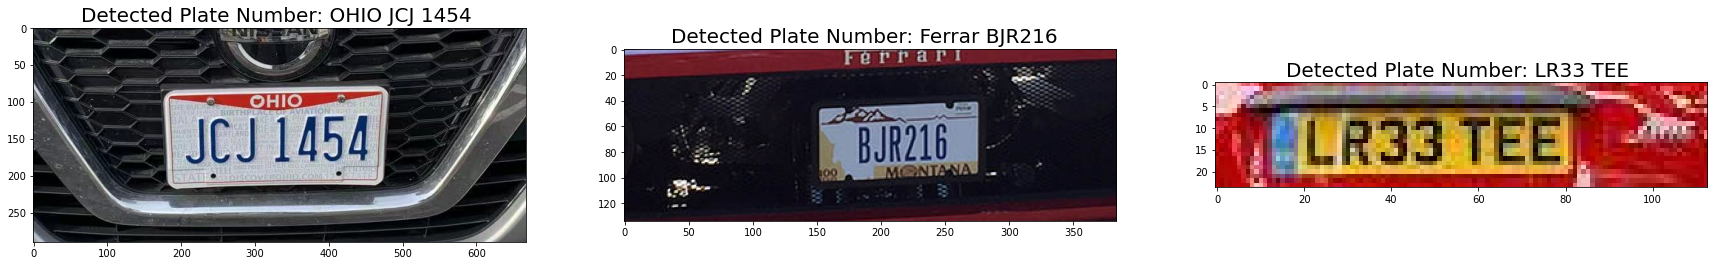

In [36]:
import easyocr

# set up the easyocr reader with english
reader = easyocr.Reader(['en'])

# display the plates with detected text
plt.figure(figsize=(30,10))
for i, plate in enumerate(plate_image_list):
  plt.subplot(1, len(plate_image_list), i+1)
  plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))

  bounds = reader.readtext(plate)
  title_text = ''
  for text in bounds:
    title_text += text[1] + ' '
  plt.title('Detected Plate Number: ' + title_text, fontdict={'fontsize':20})